# 수화 코드

In [1]:
import cv2 #카메라 사용
import numpy as np
import keyboard 
import time 
import mediapipe as mp

max_num_hands=1  # 손은 최대 1개만 인식
gesture = { # 17가지나 되는 제스처 라벨, 각 라벨의 제스처 데이터는 이미 수집됨 (제스처 데이터 == 손가락 관절의 각도, 각각의 라벨)
    0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',
    8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'i love you',
    15:'spacing',16:'clear'
}

mp_hands=mp.solutions.hands   # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티1
mp_drawing = mp.solutions.drawing_utils # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티2
hands=mp_hands.Hands(
    max_num_hands=max_num_hands, 
    min_detection_confidence=0.5, #최소 탐지 신뢰도 기본값 = 0.5
    min_tracking_confidence=0.5 #최소 추적 신뢰도 기본값 = 0.5
)

file=np.genfromtxt('./data/dataSet.txt',delimiter=',') #데이터 셋 불러오기
angle = file[:,:-1].astype(np.float32) # 각도
label = file[:, -1].astype(np.float32) # 라벨
knn=cv2.ml.KNearest_create() # knn(k-최근접 알고리즘)으로
knn.train(angle,cv2.ml.ROW_SAMPLE,label) # 학습!

# 카메라 열기
# 0은 기본 카메라(장치관리자에 저장되어있는 순서대로), 카메라가 두 대면 1~2
cap=cv2.VideoCapture(0) 

startTime = time.time()
prev_index = 0
sentence = ''
recognlzeDelay = 1

while True:
    ret,img = cap.read() #카메라에서 1개의 프레임씩 읽어온다.
    if not ret: 
        #카메라를 찾을 수 없는 경우
        break
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #BGR을 RGB로 바꾸어줌
    result = hands.process(imgRGB)
    
    # 각도를 인식하는 부분
    if result.multi_hand_landmarks is not None: #만약 손을 인식하면?
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21,3))  # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
            for j,lm in enumerate(res.landmark):
                joint[j] = [lm.x,lm.y,lm.z]# 각 joint마다 x,y,z 좌표 저장
            
            #joint와 joint 사이의 각도 계산
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint

            v = v2 - v1 #각 관절에 대한 벡터
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터의 정규화(크기 1 벡터) = v / 벡터의 크기
            compareV1 = v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:]
            compareV2 = v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:]
            angle = np.arccos(np.einsum('nt,nt->n',compareV1,compareV2))#내적 후 arcos으로 각도를 구해줌
            angle = np.degrees(angle) #라디안을 각도로 변환
            
            data = np.array([angle], dtype=np.float32) #float32로 데이터 지정하기
            ret, result, neighbors,dist = knn.findNearest(data,3) #k=3일 때 값을 구현한다
            index = int(result[0][0]) # 인덱스를 저장
            
            cv2.putText(img, text=gesture[index].upper(), org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
            # 손 0번 좌표 아래에 글씨 입력
            
            if index in gesture.keys(): #index는 현재 내가 하고 있는 제스처,prev_index는 저번 프레임에 내가 한 제스처
                if index != prev_index: # index와 prev_index가 다르면 
                    startTime = time.time() # 시간 초기화
                    prev_index = index
                else:
                    if time.time() - startTime > recognlzeDelay: # index와 prev_index가 같다면 
                        if index == 15:                          #해당 제스처를 시작한 시간과 현재 시간을 비교해 1초가 지났다면 밑에 띄어주는코드입니다
                            sentence += ' '
                        elif index == 16:
                            sentence = ''
                        else:
                            sentence += gesture[index]
                        startTime = time.time()

            mp_drawing.draw_landmarks(img,res,mp_hands.HAND_CONNECTIONS) # 손에 랜드마크를 그려준다.
    
    #글씨 띄우기
    cv2.putText(img,sentence,(20,440),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)
    
    cv2.imshow('HandTracking',img) #화면 출력
    if cv2.waitKey(1) == ord('q'): #q누르면 화면 끄기
            break
cap.release() #오픈한 캡쳐 객체를 해제합니다
cv2.destroyAllWindows() #윈도우 제거

## 1.사용한 라이브러리

In [ ]:
import cv2 #카메라 사용
import numpy as np
import keyboard 
import time 
import mediapipe as mp

## 2. 미디어파이프 손 모델과 제스처 종류

In [ ]:
max_num_hands=1  # 손은 최대 1개만 인식
gesture = { # 17가지나 되는 제스처 라벨, 각 라벨의 제스처 데이터는 이미 수집됨 (제스처 데이터 == 손가락 관절의 각도, 각각의 라벨)
    0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',
    8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'i love you',
    15:'spacing',16:'clear'
}

mp_hands=mp.solutions.hands   # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티1
mp_drawing = mp.solutions.drawing_utils # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티2
hands=mp_hands.Hands(
    max_num_hands=max_num_hands, 
    min_detection_confidence=0.5, #최소 탐지 신뢰도 기본값 = 0.5
    min_tracking_confidence=0.5 #최소 추적 신뢰도 기본값 = 0.5
)

##### 데이터
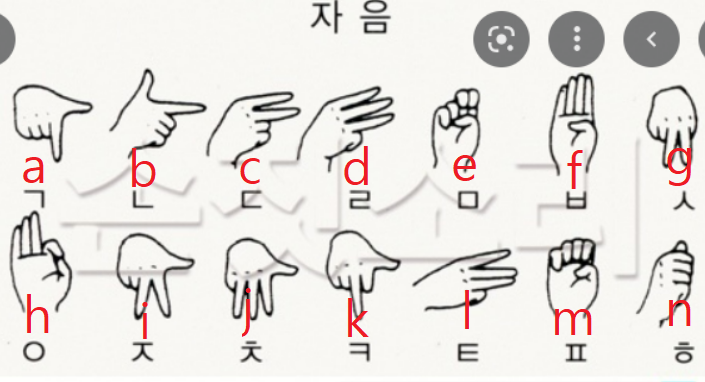

##### MAX_NUM_HANDS(손_최대_갯수)
- 탐지할 수 있는 최대 손 수입니다. 기본값은 2입니다.

##### MIN_DETECTION_CONFIDENCE(최소_탐지_신뢰도)
- 탐지가 성공한 것으로 간주되는 손 감지 모델의 최소 신뢰 값([0.0, 1.0]). 기본값은 0.5입니다.

##### MIN_TRACKING_CONFIDENCE(최소_추척_신뢰도)
- 손 랜드마크 추적 모델의 최소 신뢰 값([0.0, 1.0])이 성공적으로 추적된 것으로 간주됩니다 만약 그렇지 않다면 다음 입력 영상에서 기준 손 탐지가 자동으로 호출됩니다. 이 솔루션을 높은 값으로 설정하면 지연 시간이 길어지는 대신 솔루션의 정확성을 높일 수 있습니다.

## 3. 데이터 가져오기

In [ ]:
file=np.genfromtxt('./data/test.txt',delimiter=',') #데이터 셋 불러오기
angle = file[:,:-1].astype(np.float32) # 각도
label = file[:, -1].astype(np.float32) # 라벨
knn=cv2.ml.KNearest_create() # knn(k-최근접 알고리즘)으로
knn.train(angle,cv2.ml.ROW_SAMPLE,label) # 학습!

## 4.카메라로 비디오 읽기

In [ ]:
# 카메라 열기
# 0은 기본 카메라(장치관리자에 저장되어있는 순서대로), 카메라가 두 대면 1~2
cap=cv2.VideoCapture(0) 

startTime = time.time()
prev_index = 0
sentence = ''
recognlzeDelay = 1 

while True:
    ret,img = cap.read() #카메라에서 1개의 프레임씩 읽어온다.
    if not ret: 
        #카메라를 찾을 수 없는 경우
        break
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #BGR을 RGB로 바꾸어줌
    result = hands.process(imgRGB)  

## 4. 각도 인식
### 4-1. joint x,y,z 저장

In [ ]:
    # 각도를 인식하는 부분
    if result.multi_hand_landmarks is not None: #만약 손을 인식하면?
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21,3))  # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
            for j,lm in enumerate(res.landmark):
                joint[j] = [lm.x,lm.y,lm.z]# 각 joint마다 x,y,z 좌표 저장

In [12]:
print(joint)

[[ 2.66878530e-02  5.88120282e-01 -4.99278713e-07]
 [ 1.38878107e-01  5.20306289e-01 -5.16100936e-02]
 [ 2.10974544e-01  3.24959099e-01 -6.39191717e-02]
 [ 2.23846048e-01  1.44068733e-01 -7.46439621e-02]
 [ 1.47107273e-01  5.75546026e-02 -7.53220990e-02]
 [ 9.72891822e-02  1.69562727e-01  6.64423278e-04]
 [ 1.00739561e-01  3.43669802e-02 -6.06324635e-02]
 [ 1.32666469e-01  1.56308368e-01 -9.68018249e-02]
 [ 1.34686589e-01  2.41132975e-01 -1.09415695e-01]
 [ 3.05123664e-02  1.89237550e-01  5.05969953e-03]
 [ 2.84379050e-02  4.96212542e-02 -6.19667284e-02]
 [ 7.68865496e-02  1.99267447e-01 -8.56930614e-02]
 [ 7.70469606e-02  2.78778166e-01 -8.22162107e-02]
 [-3.37256640e-02  2.29122281e-01 -2.24599452e-03]
 [-3.20169181e-02  9.83971804e-02 -6.95904419e-02]
 [ 2.20446587e-02  2.37896562e-01 -5.35101965e-02]
 [ 2.53637657e-02  3.12866718e-01 -2.19525732e-02]
 [-9.84008759e-02  2.83478945e-01 -1.41188838e-02]
 [-7.35770017e-02  1.86604187e-01 -5.71414344e-02]
 [-2.96290964e-02  2.74269074e-

In [8]:
print(len(joint))

21


### 4-2. 각도 계산

In [ ]:
            #joint와 joint 사이의 각도 계산
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
            v = v2 - v1 #각 관절에 대한 벡터

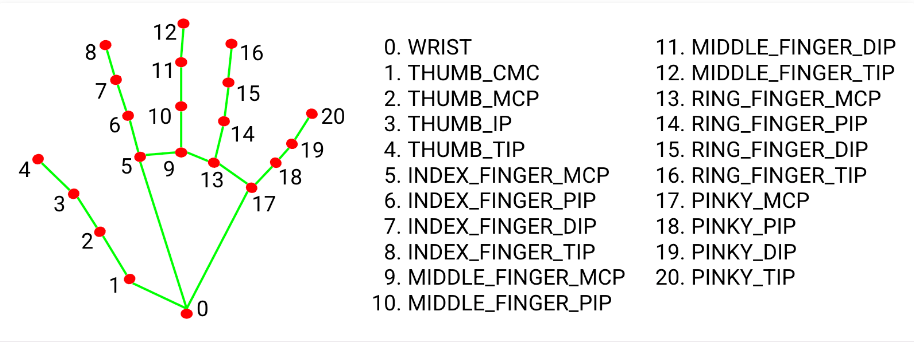

In [11]:
print(v1[0][0])
print(v2[0][0])
print(v2[0][0]-v1[0][0])
print(v[0][0])

0.026687853038311005
0.13887810707092285
0.11219025403261185
0.11219025403261185


In [ ]:
v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터의 정규화(크기 1 벡터) = v / 벡터의 크기
#필수적으로 정규화 벡터를 사용할 필요는 없다. 그러나 정규화 벡터는 식을 굉장히 축소시켜주고, 따라서 API 또한 매우 간단해진다. 

In [18]:
print(v)

[[ 0.86510221 -0.31580757 -0.389697  ]
 [ 0.58998837 -0.80377921 -0.07650298]
 [ 0.08739958 -0.99116477 -0.09976834]
 [-0.45692581 -0.88581106 -0.08097878]
 [ 0.20466214 -0.97883039  0.00211549]
 [ 0.20003327 -0.93712893 -0.28596515]
 [ 0.06726647 -0.96788067 -0.24224414]
 [ 0.19357563 -0.9605568  -0.19964745]
 [ 0.01822384 -0.99979798 -0.00847923]
 [ 0.14523466 -0.93510671 -0.32323728]
 [ 0.14506414 -0.96435677 -0.22129712]
 [ 0.23404129 -0.97114417 -0.04586586]
 [-0.13795196 -0.98936906 -0.04602303]
 [-0.03775562 -0.91572009 -0.40003904]
 [ 0.13479227 -0.98687014 -0.08898518]
 [ 0.18603008 -0.979264    0.0802174 ]
 [-0.34499965 -0.93189091 -0.11204719]
 [-0.05194398 -0.95519736 -0.29137576]
 [-0.07560021 -0.99698955 -0.01721775]
 [ 0.11365568 -0.98880633  0.09666656]]


np.newaxis는 기존 배열이 증가하는 것입니다.

참고 : http://daplus.net/python-numpy-newaxis%EB%8A%94-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%9E%91%EB%8F%99%ED%95%98%EB%A9%B0-%EC%96%B8%EC%A0%9C-%EC%82%AC%EC%9A%A9%ED%95%A9%EB%8B%88%EA%B9%8C/

In [ ]:
compareV1 = v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:]
compareV2 = v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:]
angle = np.arccos(np.einsum('nt,nt->n',compareV1,compareV2))#내적 후 arccos으로 각도를 구해줌
#arccos 하는 이유는 내적은 cos으로 나옴
#angle = np.arccos(np.dot(compareV1,compareV2)) 
angle = np.degrees(angle) #라디안을 각도로 변환

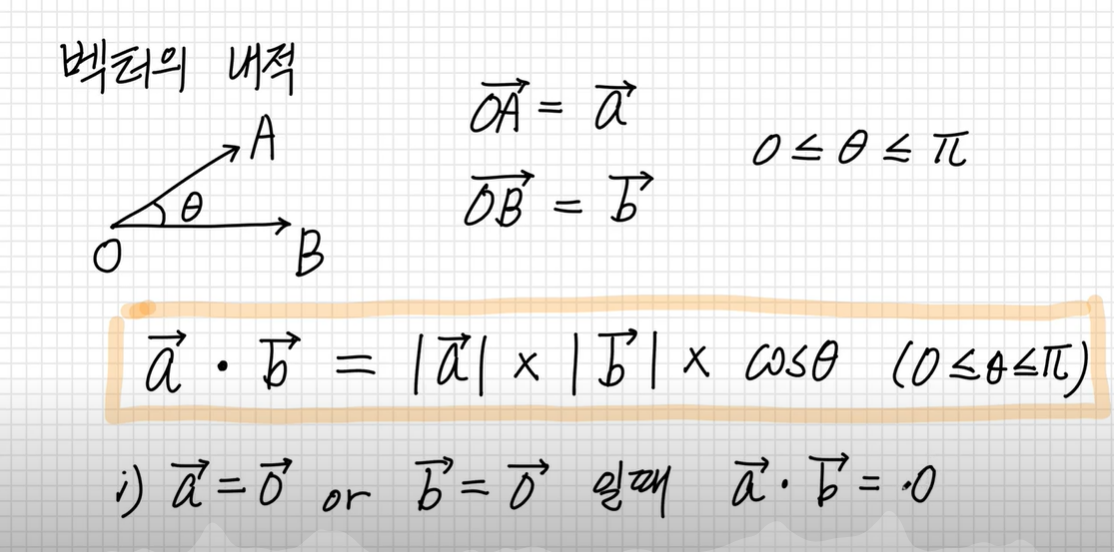

np.einsum 참고 : https://ajcr.net/Basic-guide-to-einsum/

np.arccos 참고 : https://everyday-image-processing.tistory.com/106

np.dot 참고 : https://jimmy-ai.tistory.com/75

## 5.KNN (k 최근접 이웃 알고리즘)

In [ ]:
data = np.array([angle], dtype=np.float32) #float32로 데이터 지정하기
ret, result, neighbors,dist = knn.findNearest(data,3) #k=3일 때 값을 구현한다
index = int(result[0][0]) # 인덱스를 저장

cv2.putText(img, text=gesture[index].upper(), org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
# 손 0번 좌표 아래에 글씨 입력

knn 참고 : https://deep-learning-study.tistory.com/286

## 6.글자 화면에 띄우기

In [ ]:
            if index in gesture.keys(): #index는 현재 내가 하고 있는 제스처,prev_index는 저번 프레임에 내가 한 제스처
                if index != prev_index: # index와 prev_index가 다르면 
                    startTime = time.time() # 시간 초기화
                    prev_index = index
                else:
                    if time.time() - startTime > recognlzeDelay: # index와 prev_index가 같다면 
                        if index == 15:                          #해당 제스처를 시작한 시간과 현재 시간을 비교해 1초가 지났다면 밑에 띄어주는코드입니다
                            sentence += ' '
                        elif index == 16:
                            sentence = ''
                        else:
                            sentence += gesture[index]
                        startTime = time.time()

            mp_drawing.draw_landmarks(img,res,mp_hands.HAND_CONNECTIONS) # 손에 랜드마크를 그려준다.
    
    #글씨 띄우기
    cv2.putText(img,sentence,(20,440),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)

## 7.카메라 끄기

In [ ]:
    cv2.imshow('HandTracking',img) #화면 출력
    if cv2.waitKey(1) == ord('q'): #q누르면 화면 끄기
            break
cap.release() #오픈한 캡쳐 객체를 해제합니다
cv2.destroyAllWindows() #윈도우 제거

각도는 같은데 뒤에 라벨이 다를 때 인식을 잘 못하는 것 같아서 코드를 더 추가해서 보완하면 좋을 것 같습니다.

정적인 수화만 인식하는 단점이 있습니다.

# 데이터 셋 모으기

각도 저장을 제공된 데이터 셋에서 추가 하는 방식으로 저장해서 제가 원하는 동작 각도값을 저장하는 방법을 모르겠어서

노가다로 라벨값 바꾸면서 데이터셋을 만들었습니다.....

여러분은 이렇게 하지 마세요ㅎㅎㅎㅎㅎㅎ

데이터셋을 구할 수 있다면 빠르게 구현이 가능하다는 점이 장점입니다.

In [30]:
import cv2 #카메라 사용
import numpy as np
import keyboard 
import time 
import mediapipe as mp

max_num_hands=1 # 손은 최대 1개만 인식

mp_hands=mp.solutions.hands  # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티1
mp_drawing = mp.solutions.drawing_utils # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티2
hands=mp_hands.Hands(
    max_num_hands=max_num_hands, 
    min_detection_confidence=0.5, #최소 탐지 신뢰도 기본값 = 0.5
    min_tracking_confidence=0.5 #최소 추적 신뢰도 기본값 = 0.5
)

f=open('test.txt','w') #txt 파일에 내용을 쓰기 위해 파일 생성

# 카메라 열기
# 0은 기본 카메라(장치관리자에 저장되어있는 순서대로), 카메라가 두 대면 1~2
cap=cv2.VideoCapture(0) 

while True: 
    ret,img = cap.read() #카메라에서 1개의 프레임씩 읽어온다.
    if not ret:
        #카메라를 찾을 수 없는 경우
        break
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #BGR을 RGB로 바꾸어줌
    result = hands.process(imgRGB)
    
    # 각도를 인식하는 부분
    if result.multi_hand_landmarks is not None: #만약 손을 인식하면?
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21,3)) # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
            for j,lm in enumerate(res.landmark):
                joint[j] = [lm.x,lm.y,lm.z] # 각 joint마다 x,y,z 좌표 저장
            #joint와 joint 사이의 각도 계산
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint

            v = v2 - v1 #각 관절에 대한 벡터
            
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터의 정규화(크기 1 벡터) = v / 벡터의 크기
            compareV1 = v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:]
            compareV2 = v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:]
            angle = np.arccos(np.einsum('nt,nt->n',compareV1,compareV2)) #내적 후 arcos으로 각도를 구해줌
            angle = np.degrees(angle) #라디안을 각도로 변환
            if keyboard.is_pressed('a'): # a키보드를 누르면 test.txt 파일에 각도정보가 들어간다
                for num in angle:
                    num = round(num,6) #반올림
                    f.write(str(num))
                    f.write(',')
                f.write('16.00000')
                f.write('\n')
                print('---------------------')
        mp_drawing.draw_landmarks(img,res,mp_hands.HAND_CONNECTIONS) # 손에 랜드마크를 그려준다.

    cv2.imshow('HandTracking',img) #화면 출력
    if cv2.waitKey(1) == ord('q'): #q누르면 화면 끄기
            break
f.close() #test.txt파일 닫기
cap.release() #오픈한 캡쳐 객체를 해제합니다
cv2.destroyAllWindows() #윈도우 제거

## 1.사용한 라이브러리

In [ ]:
import cv2 #카메라 사용
import numpy as np
import keyboard 
import time 
import mediapipe as mp

## 2. 미디어파이프 손 모델과 파일 생성

In [ ]:
max_num_hands=1 # 손은 최대 1개만 인식

mp_hands=mp.solutions.hands  # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티1
mp_drawing = mp.solutions.drawing_utils # 웹캠 영상에서 손가락 마디와 포인트를 그릴 수 있게 도와주는 유틸리티2
hands=mp_hands.Hands(
    max_num_hands=max_num_hands, 
    min_detection_confidence=0.5, #최소 탐지 신뢰도 기본값 = 0.5
    min_tracking_confidence=0.5 #최소 추적 신뢰도 기본값 = 0.5
)
f=open('test.txt','w') #txt 파일에 내용을 쓰기 위해 파일 생성

##### MAX_NUM_HANDS(손_최대_갯수)
- 탐지할 수 있는 최대 손 수입니다. 기본값은 2입니다.

##### MIN_DETECTION_CONFIDENCE(최소_탐지_신뢰도)
- 탐지가 성공한 것으로 간주되는 손 감지 모델의 최소 신뢰 값([0.0, 1.0]). 기본값은 0.5입니다.

##### MIN_TRACKING_CONFIDENCE(최소_추척_신뢰도)
- 손 랜드마크 추적 모델의 최소 신뢰 값([0.0, 1.0])이 성공적으로 추적된 것으로 간주됩니다 만약 그렇지 않다면 다음 입력 영상에서 기준 손 탐지가 자동으로 호출됩니다. 이 솔루션을 높은 값으로 설정하면 지연 시간이 길어지는 대신 솔루션의 정확성을 높일 수 있습니다.

## 3. 카메라로 비디오 읽기

In [ ]:
# 카메라 열기
# 0은 기본 카메라(장치관리자에 저장되어있는 순서대로), 카메라가 두 대면 1~2
cap=cv2.VideoCapture(0) 

In [ ]:
while True:  #무한루프
    ret,img = cap.read() #카메라에서 1개의 프레임씩 읽어온다.
    if not ret:
        #카메라를 찾을 수 없는 경우
        break

In [ ]:
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #BGR을 RGB로 바꾸어줌
    result = hands.process(imgRGB)

## 4. 각도 인식
### 4-1. joint x,y,z 저장

In [ ]:
    # 각도를 인식하는 부분
    if result.multi_hand_landmarks is not None: #만약 손을 인식하면?
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21,3)) # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
            for j,lm in enumerate(res.landmark):
                joint[j] = [lm.x,lm.y,lm.z] # 각 joint마다 x,y,z 좌표 저장

In [13]:
print(joint)

[[ 2.66878530e-02  5.88120282e-01 -4.99278713e-07]
 [ 1.38878107e-01  5.20306289e-01 -5.16100936e-02]
 [ 2.10974544e-01  3.24959099e-01 -6.39191717e-02]
 [ 2.23846048e-01  1.44068733e-01 -7.46439621e-02]
 [ 1.47107273e-01  5.75546026e-02 -7.53220990e-02]
 [ 9.72891822e-02  1.69562727e-01  6.64423278e-04]
 [ 1.00739561e-01  3.43669802e-02 -6.06324635e-02]
 [ 1.32666469e-01  1.56308368e-01 -9.68018249e-02]
 [ 1.34686589e-01  2.41132975e-01 -1.09415695e-01]
 [ 3.05123664e-02  1.89237550e-01  5.05969953e-03]
 [ 2.84379050e-02  4.96212542e-02 -6.19667284e-02]
 [ 7.68865496e-02  1.99267447e-01 -8.56930614e-02]
 [ 7.70469606e-02  2.78778166e-01 -8.22162107e-02]
 [-3.37256640e-02  2.29122281e-01 -2.24599452e-03]
 [-3.20169181e-02  9.83971804e-02 -6.95904419e-02]
 [ 2.20446587e-02  2.37896562e-01 -5.35101965e-02]
 [ 2.53637657e-02  3.12866718e-01 -2.19525732e-02]
 [-9.84008759e-02  2.83478945e-01 -1.41188838e-02]
 [-7.35770017e-02  1.86604187e-01 -5.71414344e-02]
 [-2.96290964e-02  2.74269074e-

In [6]:
print(len(joint)) #총 21개 저장

21


### 4-2. 각도 계산

In [ ]:
            #joint와 joint 사이의 각도 계산
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint

            v = v2 - v1 #각 관절에 대한 벡터

In [14]:
print(v1[0][0])
print(v2[0][0])
print(v2[0][0]-v1[0][0])
print(v[0][0])

0.026687853038311005
0.13887810707092285
0.11219025403261185
0.11219025403261185


In [ ]:
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터의 정규화(크기 1 벡터) = v / 벡터의 크기

np.newaxis는 기존 배열이 증가하는 것입니다.

참고 : http://daplus.net/python-numpy-newaxis%EB%8A%94-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%9E%91%EB%8F%99%ED%95%98%EB%A9%B0-%EC%96%B8%EC%A0%9C-%EC%82%AC%EC%9A%A9%ED%95%A9%EB%8B%88%EA%B9%8C/

In [17]:
print(v)

[[ 0.86510221 -0.31580757 -0.389697  ]
 [ 0.58998837 -0.80377921 -0.07650298]
 [ 0.08739958 -0.99116477 -0.09976834]
 [-0.45692581 -0.88581106 -0.08097878]
 [ 0.20466214 -0.97883039  0.00211549]
 [ 0.20003327 -0.93712893 -0.28596515]
 [ 0.06726647 -0.96788067 -0.24224414]
 [ 0.19357563 -0.9605568  -0.19964745]
 [ 0.01822384 -0.99979798 -0.00847923]
 [ 0.14523466 -0.93510671 -0.32323728]
 [ 0.14506414 -0.96435677 -0.22129712]
 [ 0.23404129 -0.97114417 -0.04586586]
 [-0.13795196 -0.98936906 -0.04602303]
 [-0.03775562 -0.91572009 -0.40003904]
 [ 0.13479227 -0.98687014 -0.08898518]
 [ 0.18603008 -0.979264    0.0802174 ]
 [-0.34499965 -0.93189091 -0.11204719]
 [-0.05194398 -0.95519736 -0.29137576]
 [-0.07560021 -0.99698955 -0.01721775]
 [ 0.11365568 -0.98880633  0.09666656]]


In [21]:
            compareV1 = v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:]
            compareV2 = v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:]
            angle = np.arccos(np.einsum('nt,nt->n',compareV1,compareV2)) #내적 후 arccos으로 각도를 구해줌
            #arccos 하는 이유는 내적은 cos으로 나옴
#            angle = np.arccos(np.dot(compareV1,compareV2)) 
            angle = np.degrees(angle) #라디안을 각도로 변환

np.einsum 참고 : https://ajcr.net/Basic-guide-to-einsum/

np.dot 참고 : https://jimmy-ai.tistory.com/75

## 6.키보드누르면 각도정보 저장

In [ ]:
            if keyboard.is_pressed('a'): # a키보드를 누르면 test.txt 파일에 각도정보가 들어간다
                for num in angle:
                    num = round(num,6) #반올림
                    f.write(str(num))
                    f.write(',')
                f.write('16.00000')
                f.write('\n')
                print('---------------------')

## 7. 카메라 끄기

In [ ]:
        mp_drawing.draw_landmarks(img,res,mp_hands.HAND_CONNECTIONS) # 손에 랜드마크를 그려준다.

    cv2.imshow('HandTracking',img) #화면 출력
    if cv2.waitKey(1) == ord('q'): #q누르면 화면 끄기
            break
f.close() #test.txt파일 닫기
cap.release() #오픈한 캡쳐 객체를 해제합니다
cv2.destroyAllWindows() #윈도우 제거